In [168]:
import math
import dill
import datetime
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter

##
0.Импортируем данные из файлов

In [169]:
df_sessions = pd.read_csv('data/ga_sessions.csv', dtype={'session_id':'str', 'client_id': 'str',
                                                    'visit_date':'str', 'visit_time': 'str',
                                '                     visit_number':'int',
                                                    'utm_source': 'str', 'utm_medium':'str',
                                                    'utm_campaign': 'str', 'utm_medium':'str','utm_campaign':'str',
                                                    'utm_adcontent': 'str', 'utm_keyword':'str', 'device_category': 'str', 'device_os':'str', 'device_brand':'str',
                                                    'device_model': 'str', 'device_screen_resolution':'str', 'device_browser': 'str', 'geo_country':'str','geo_city':'str'})
df_hits = pd.read_csv('data/ga_hits-002.csv', usecols=['session_id', 'event_action'], dtype={'session_id':'str', 'event_action': 'str'})

#
EDA

##
Data cleaning


In [170]:
target_action = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click',
    'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']

In [171]:
indexes = list(df_hits[df_hits.event_action.isin(target_action)].index)
df_hits.loc[indexes, 'event_action_bin'] = 1
df_hits.event_action_bin = df_hits.event_action_bin.fillna(0)

In [172]:
stats_hits = df_hits.groupby(['session_id'], as_index=False)[['event_action_bin']].max()

 Объединение датафреймов

In [173]:
df_fulled = pd.merge(left=df_sessions, right=stats_hits, on='session_id', how='inner')
df_fulled.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_bin
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0


Приведение типа целевой переменной к int

In [174]:
df_fulled['event_action_bin'] = df_fulled['event_action_bin'].astype(int)
df_fulled['event_action_bin'].dtype

dtype('int64')

In [175]:
df_fulled.event_action_bin.value_counts()

0    1681952
1      50314
Name: event_action_bin, dtype: int64

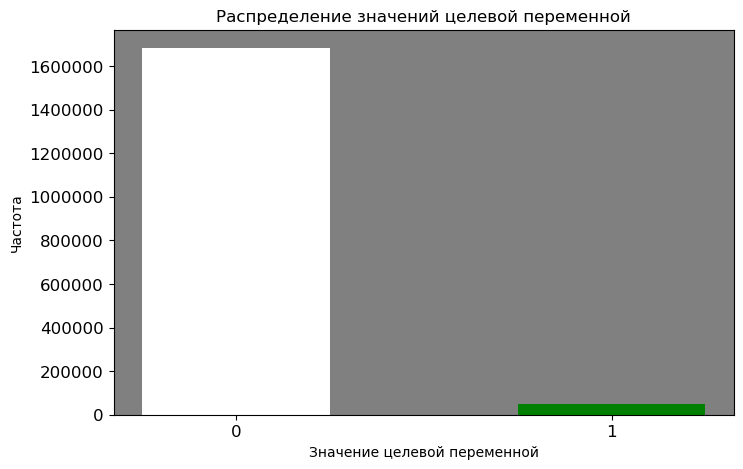

In [176]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_fulled['event_action_bin'].unique(), df_fulled['event_action_bin'].value_counts(), width=0.5, color=['white', 'green'])
ax.set_facecolor('grey')
ax.set_xlabel('Значение целевой переменной')
ax.set_ylabel('Частота')
ax.set_title('Распределение значений целевой переменной')
ax.tick_params(axis='both', labelsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

Целевое действие происходит в 2,9% случаев, что говорит о дисбалансе классов

In [177]:
df_fulled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  event_action_bin          int64 
dtypes: int64(2), object(17)
memory usage: 264.3+ MB


Данные состоят из 15 категориальных и 1 числовых признаков(session_id и client_id не имеют смылса для модеди)

In [178]:
print('Кол-во повторяющихся строк:', len(df_fulled[df_fulled.duplicated()].values))

Кол-во повторяющихся строк: 0


<AxesSubplot:>

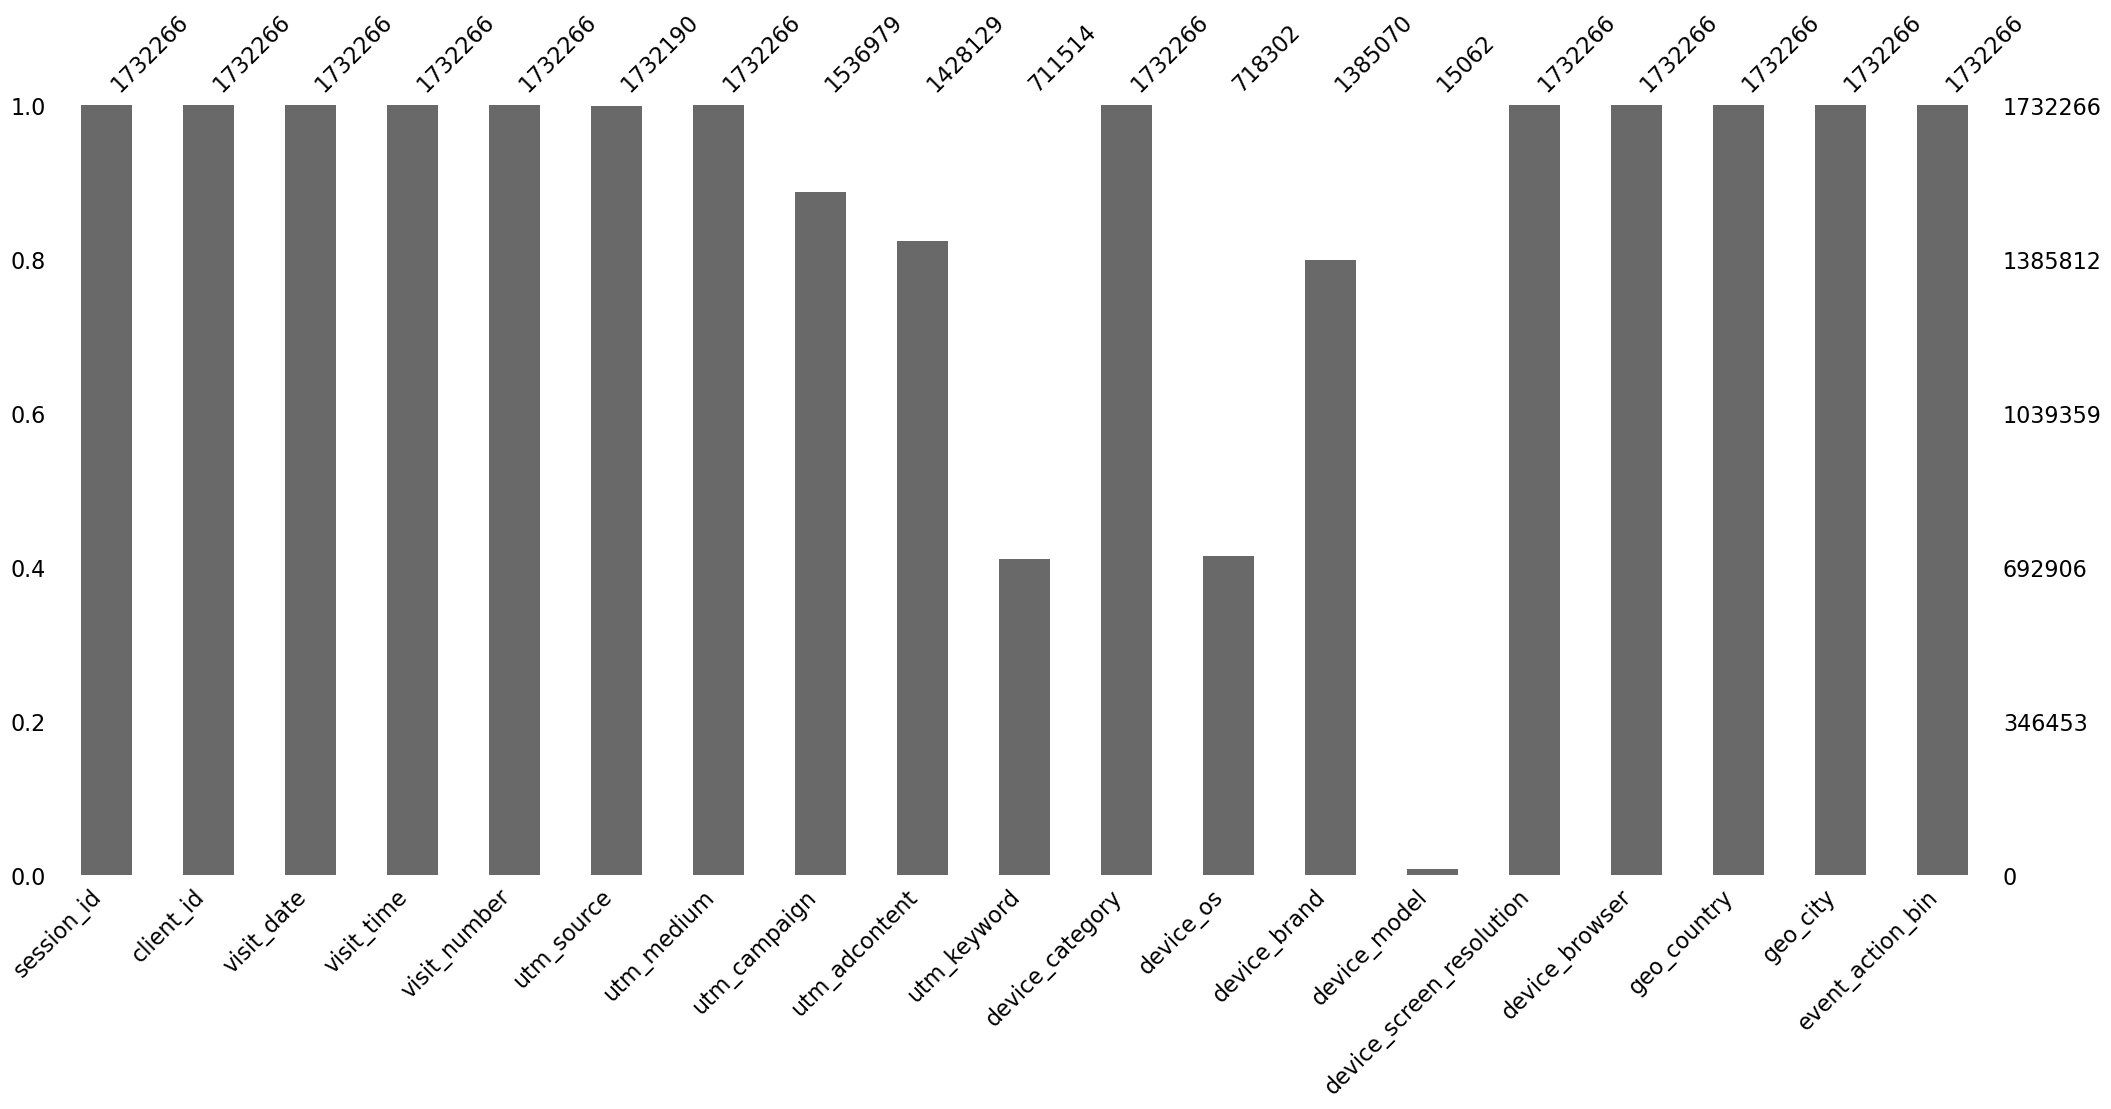

In [179]:
msno.bar(df_fulled)

<AxesSubplot:>

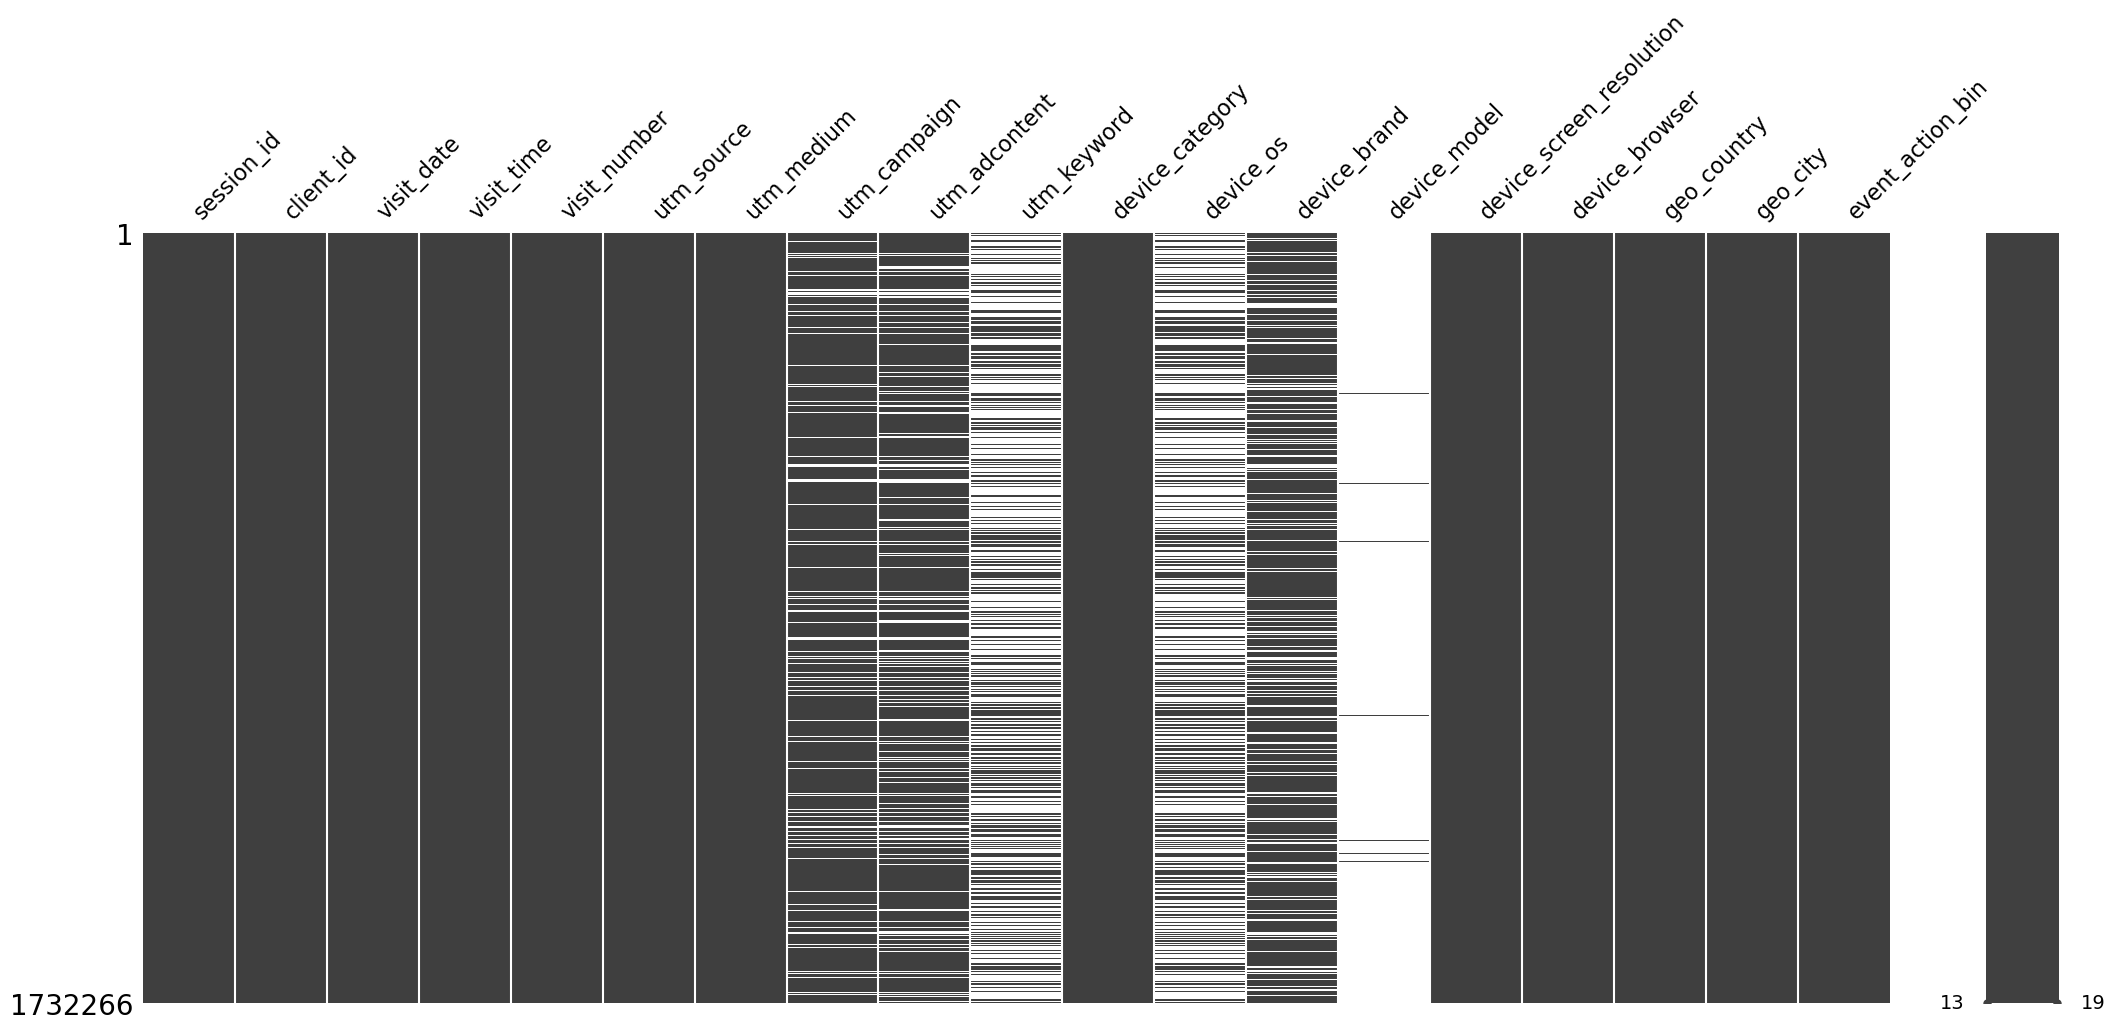

In [180]:
msno.matrix(df_fulled)

In [181]:
def using_strokes(df):
    print('Кол-во заполненных строк:', len(df.dropna()))
    print('Процент заполненных строк', round(len(df.dropna()) / len(df) * 100, 4))
using_strokes(df_fulled)
missing_values = ((df_fulled.isna().sum() / len(df_fulled)) * 100).sort_values()
print(f'Процент пропущенных значений:\n' + f'{missing_values}')

Кол-во заполненных строк: 13829
Процент заполненных строк 0.7983
Процент пропущенных значений:
session_id                   0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_city                     0.000000
event_action_bin             0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.004387
utm_campaign                11.273500
utm_adcontent               17.557177
device_brand                20.042880
device_os                   58.533966
utm_keyword                 58.925823
device_model                99.130503
dtype: float64


In [182]:
df_fulled = df_fulled.drop('device_model',axis=1)


In [183]:
df_fulled.head(1000)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_bin
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9060205874432882419.1635432235.1635432235,2109493565.1635432179,2021-10-28,17:43:55,4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,1280x720,Chrome,Russia,Moscow,0
996,9060228010692597937.1633704113.1633704113,2109498719.1633704113,2021-10-08,17:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,NaN,desktop,NaN,NaN,360x720,Chrome,Russia,Saint Petersburg,0
997,9060230793837352520.1639650889.1639650889,2109499367.1639650888,2021-12-16,13:34:49,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Moscow,0
998,9060233078745956602.1625653498.1625653498,2109499899.1625653498,2021-07-07,13:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,NaN,NaN,1440x900,Chrome,Russia,Moscow,0


In [184]:
df_fulled.loc[df_fulled['device_os'] == 'Macintosh', 'device_brand'] = 'Apple'
df_fulled.device_brand = df_fulled.device_brand.fillna('unknown')

In [185]:
for column in df_fulled.columns:
    df_fulled.loc[:, column] = df_fulled.loc[:, column].apply(lambda x: 'unknown' if x == '(not set)' else x)

In [186]:
def os_recovery(df):
    stats = df.groupby([df.columns[0], df.columns[1]], as_index=False)[df.columns[2]].agg(pd.Series.mode)
    for i in range(0, len(stats)):
        try:
            index_list = list(df[(df[df.columns[2]].isna()) & (df[df.columns[0]] == stats.loc[i, df.columns[0]]) &  (df[df.columns[1]] == stats.loc[i, df.columns[1]])].index)

            df.loc[index_list, df.columns[2]] = stats.loc[i, df.columns[2]]
        except:
            pass
    df[df.columns[2]][df[df.columns[2]].isna()] = 'unknown'
    return df[df.columns[2]]

df_fulled.device_os = os_recovery(df_fulled.loc[:, ['device_brand', 'device_category', 'device_os']])

In [187]:
df_fulled.head(1000)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_bin
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9060205874432882419.1635432235.1635432235,2109493565.1635432179,2021-10-28,17:43:55,4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,puhZPIYqKXeFPaUviSjo,desktop,Windows,unknown,1280x720,Chrome,Russia,Moscow,0
996,9060228010692597937.1633704113.1633704113,2109498719.1633704113,2021-10-08,17:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,NaN,desktop,Windows,unknown,360x720,Chrome,Russia,Saint Petersburg,0
997,9060230793837352520.1639650889.1639650889,2109499367.1639650888,2021-12-16,13:34:49,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Moscow,0
998,9060233078745956602.1625653498.1625653498,2109499899.1625653498,2021-07-07,13:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,Windows,unknown,1440x900,Chrome,Russia,Moscow,0


In [188]:
utm_nan = list(df_fulled[(df_fulled.utm_keyword.isna()) & (df_fulled.utm_campaign.isna()) & (df_fulled.utm_adcontent.isna())].index) + \
          list(df_fulled[df_fulled.utm_source.isna()].index)
df_full = df_fulled.drop(axis=0, index=utm_nan)
df_full.shape

(1611275, 18)

In [189]:
def utm_recovery(df):
    stats = df.groupby([df.columns[0], df.columns[1], df.columns[2]], as_index=False)[df.columns[3]].agg(pd.Series.mode)
    for i in range(0, len(stats)):
        try:
            index_list = list(df[(df[df.columns[3]].isna()) & (df[df.columns[0]] == stats.loc[i, df.columns[0]]) &  (df[df.columns[1]] == stats.loc[i, df.columns[1]])
                    & (df[df.columns[2]] == stats.loc[i, df.columns[2]])].index)
            df.loc[index_list, df.columns[3]] = stats.loc[i, df.columns[3]]
        except:
            pass
    df[df.columns[3]][df[df.columns[3]].isna()] = 'unknown'
    return df[df.columns[3]]

df_full.utm_campaign = utm_recovery(df_full.loc[:, ['utm_source', 'utm_medium', 'utm_adcontent', 'utm_campaign']])
df_full.utm_adcontent = utm_recovery(df_full.loc[:, ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent']])
df_full.utm_keyword = utm_recovery(df_full.loc[:, ['utm_adcontent', 'utm_medium', 'utm_campaign', 'utm_keyword']])

In [190]:
using_strokes(df_full)
print('Количество пропущенных значений в столбцах:')
using_strokes(df_full)

Кол-во заполненных строк: 1611275
Процент заполненных строк 100.0
Количество пропущенных значений в столбцах:
Кол-во заполненных строк: 1611275
Процент заполненных строк 100.0


In [191]:
df_full['device_browser'] = df_full['device_browser'].apply(lambda x: x.split(' ')[0].lower()).replace({'helloworld':'other',
                                                                                                        '[fban':'other', 'mrchrome':'chrome', 'MyApp':'other', 'nokiax2-02':'other', 'nokia501':'other', 'com.zhiliaoapp.musically':
                                                                                                            'other', 'threads':'other'})
df_full.device_browser.unique()

array(['chrome', 'samsung', 'safari', 'yabrowser', 'android', 'opera',
       'firefox', 'edge', 'other', 'uc', 'instagram', 'mozilla',
       'unknown', 'coc', 'internet', 'puffin', 'com.vk.vkclient',
       'maxthon', 'amazon', 'myapp', 'netfront', 'mt6735_td', 'konqueror',
       'seamonkey', 'iron'], dtype=object)

##
Data visualization

In [192]:
stat_session_id = df_full.groupby(['visit_date'], as_index=False)[['session_id']].count()
stat_session_id = stat_session_id.rename(columns={'session_id': 'session_count'}).sort_values(by='visit_date', ascending=True)
stat_session_id.head(3)

,visit_date,session_count
0,2021-05-19,703
1,2021-05-21,815
2,2021-05-22,699


In [193]:
stat_event_action = df_full.groupby(['visit_date'], as_index=False)[['event_action_bin']].sum()
stat_event_action = stat_event_action.rename(columns={'event_action_bin': 'count_success_event_action'}).sort_values(by='visit_date', ascending=True)
stat_event_action.head(3)

,visit_date,count_success_event_action
0,2021-05-19,50
1,2021-05-21,0
2,2021-05-22,10


In [194]:
stat_event_conversion = df_full.groupby(['visit_date'], as_index=False).agg({'event_action_bin': 'mean'})
stat_event_conversion = stat_event_conversion.rename(columns={'event_action_bin': 'conversion'})
stat_event_conversion.head(3)


,visit_date,conversion
0,2021-05-19,0.071124
1,2021-05-21,0.000000
2,2021-05-22,0.014306


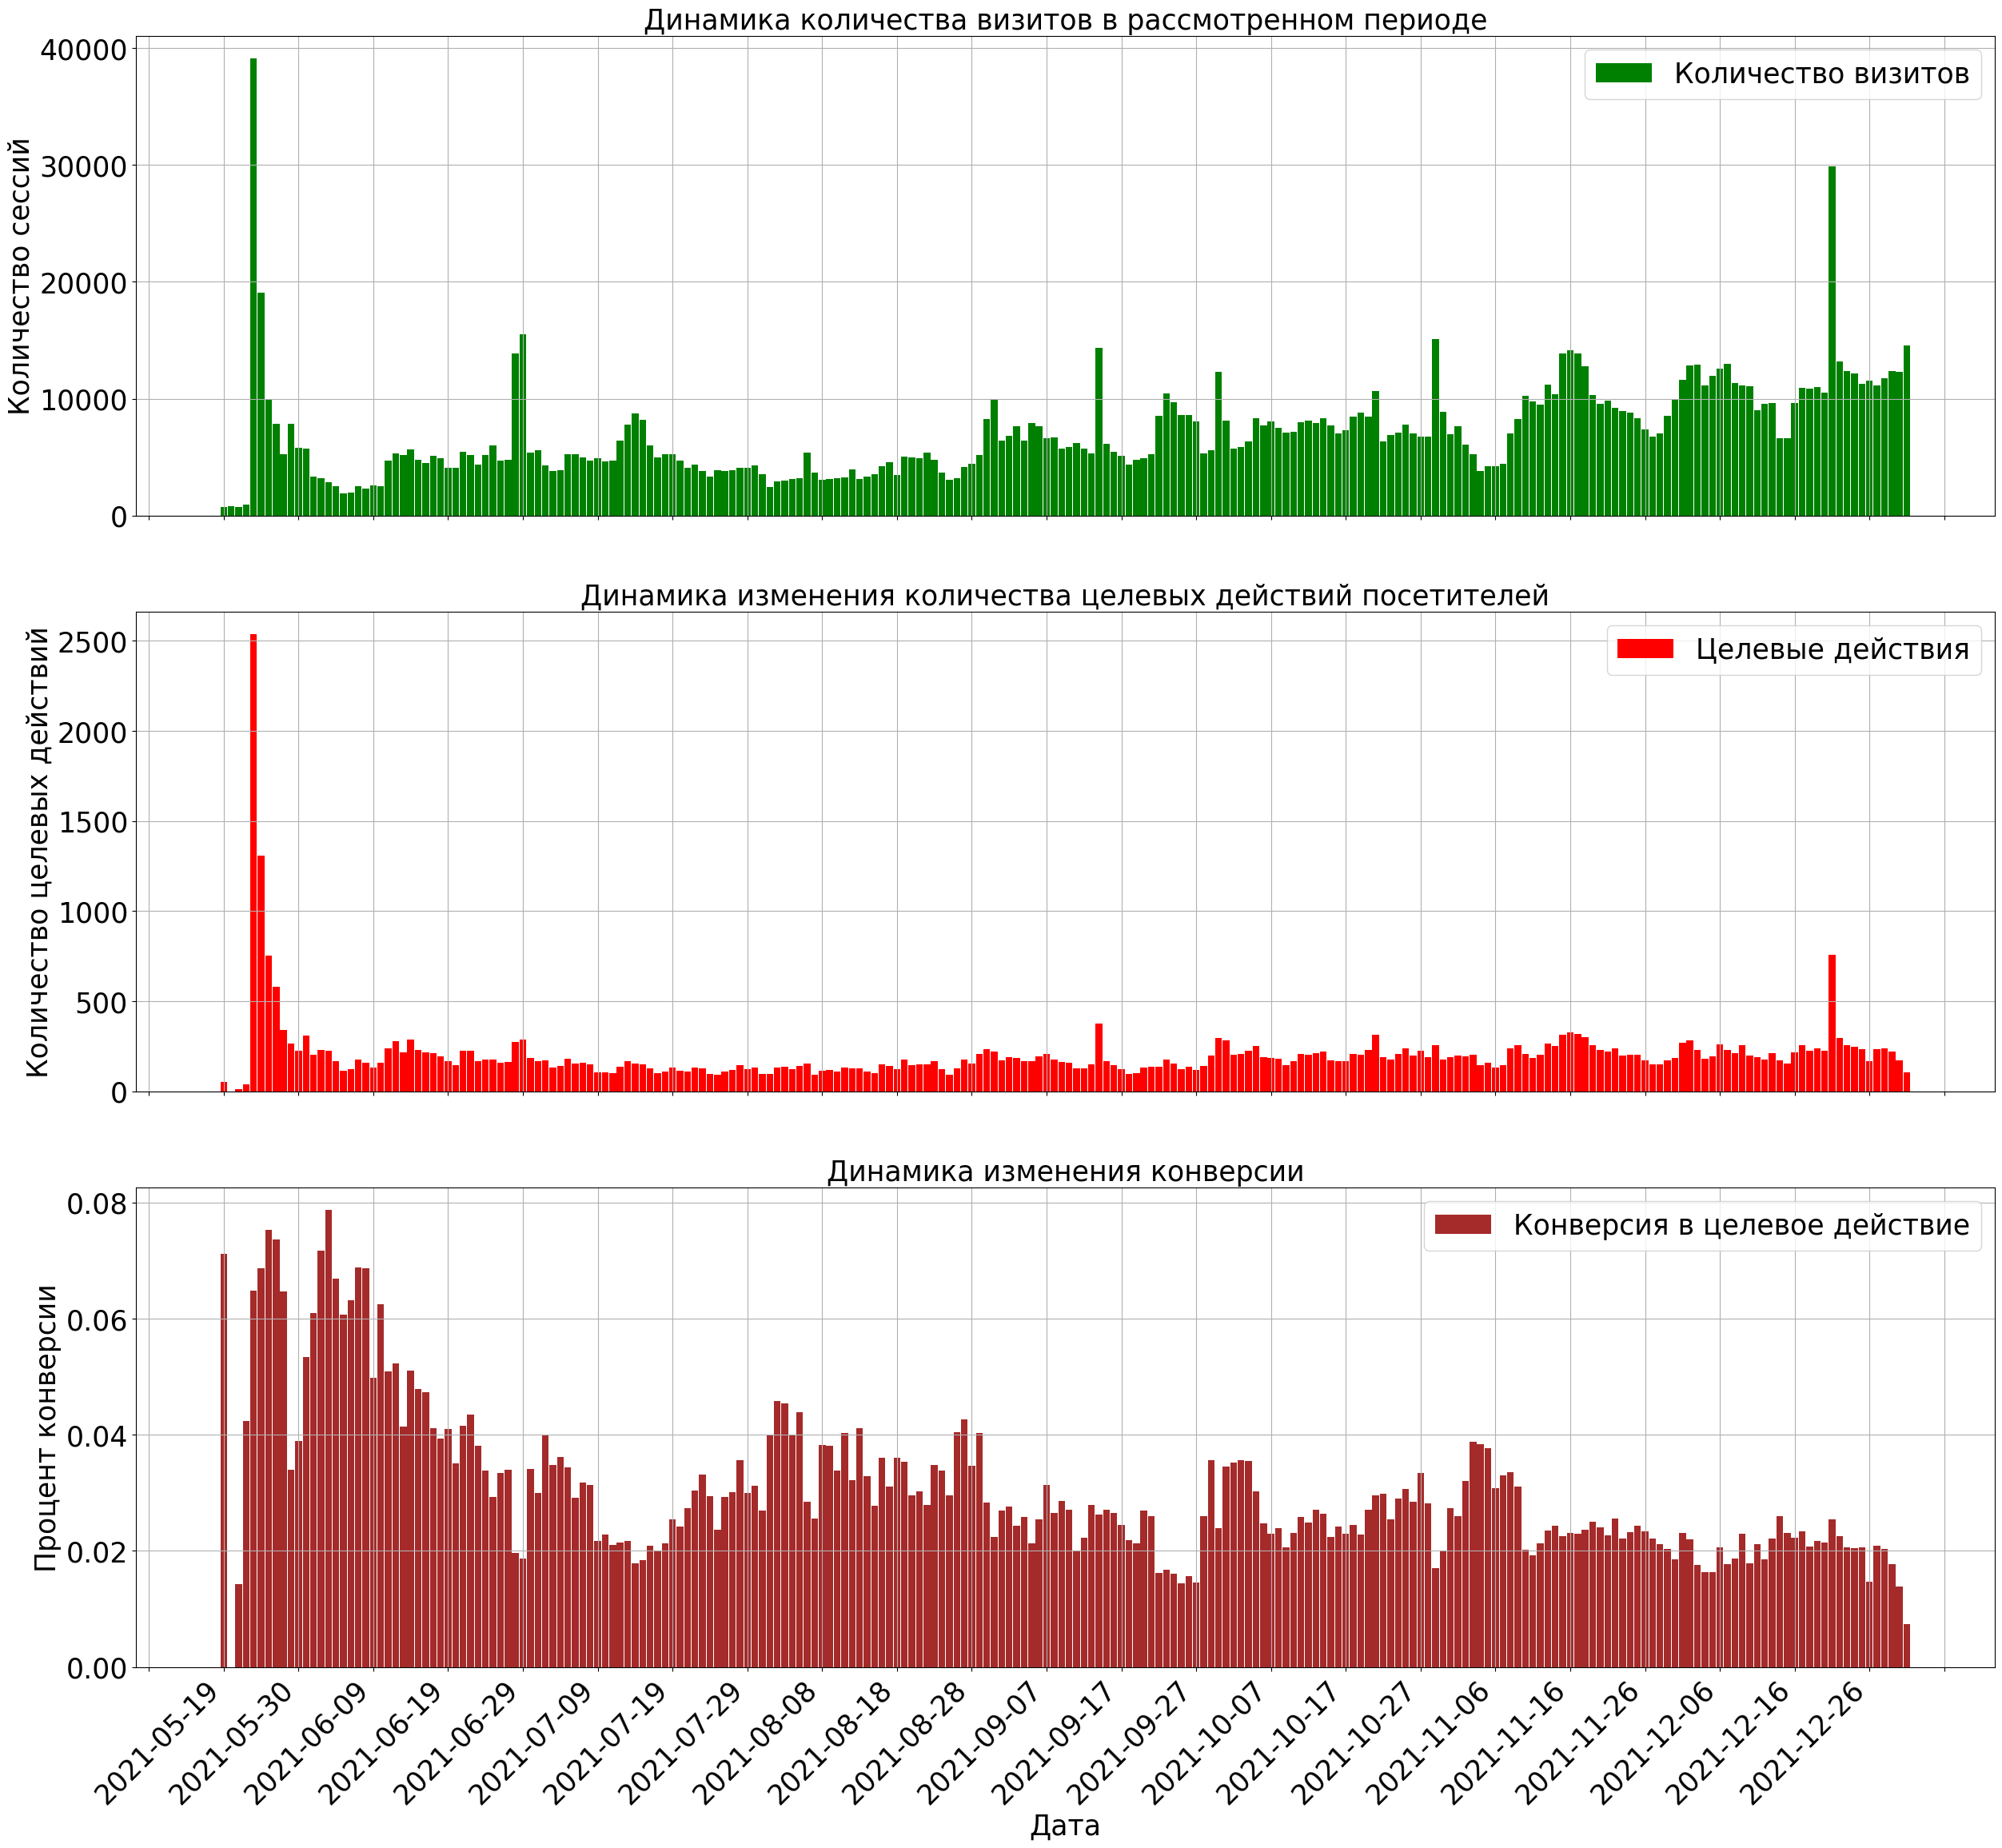

In [195]:
fig, ax = plt.subplots(3, 1, figsize=(30, 30))
ax[0].bar(stat_session_id['visit_date'], stat_session_id['session_count'], width=0.9, color='green', \
          label='Количество визитов')
ax[1].bar(stat_event_action['visit_date'], stat_event_action['count_success_event_action'], width=0.9, color='red', \
          label='Целевые действия')
ax[2].bar(stat_event_conversion['visit_date'], stat_event_conversion['conversion'], width=0.9, color='brown', \
          label='Конверсия в целевое действие')

ax[0].legend(loc='upper right', fontsize = 25)
ax[1].legend(loc='upper right', fontsize = 25)
ax[2].legend(loc='upper right', fontsize = 25)

ax[0].set_title('Динамика количества визитов в рассмотренном периоде', fontsize = 25)
ax[1].set_title('Динамика изменения количества целевых действий посетителей', fontsize = 25)
ax[2].set_title('Динамика изменения конверсии', fontsize = 25)

ax[0].set_xlabel('Дата')
ax[1].set_xlabel('Дата')
ax[2].set_xlabel('Дата', fontsize = 25)

ax[0].set_ylabel('Количество сессий', fontsize = 25)
ax[1].set_ylabel('Количество целевых действий', fontsize = 25)
ax[2].set_ylabel('Процент конверсии', fontsize = 25)

ax[0].tick_params(axis='both', labelsize=25)
ax[1].tick_params(axis='both', labelsize=25)
ax[2].tick_params(axis='both', labelsize=25)

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(10))

ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.autofmt_xdate(rotation=45);

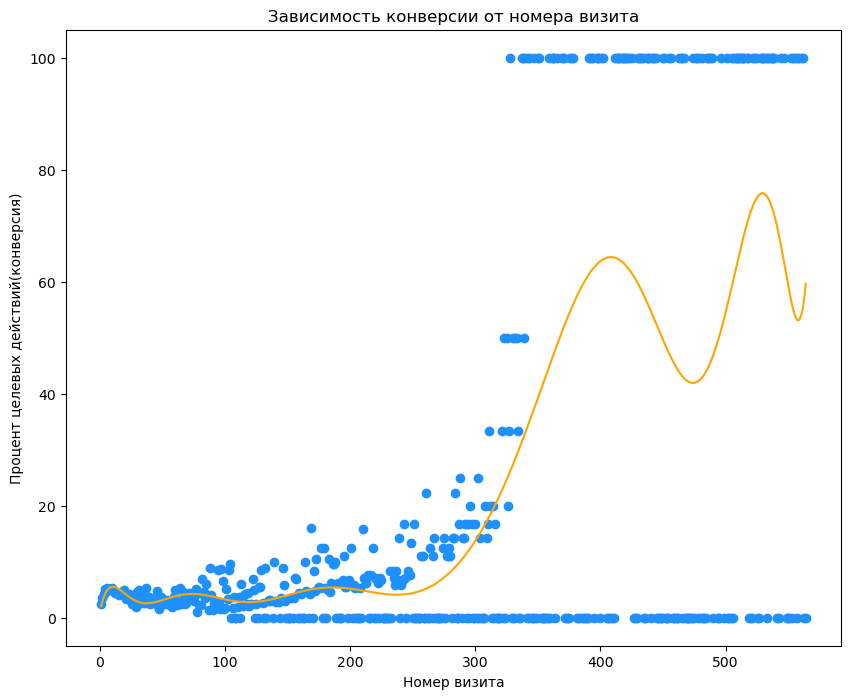

In [196]:
stats1 = df_full.groupby(['event_action_bin', 'visit_number'], as_index=False)[['session_id']].count()
stats1 = stats1.rename(columns={'session_id': 'count'}).sort_values(by='visit_number', ascending=True)
p_set = set()
for elem in stats1['visit_number']:
    p_set.add(elem)

chart_coords1 = []

for i in p_set:

    chart_coords1.append((i, (sum(stats1.event_action_bin[stats1['visit_number'] == i] * \
                                  stats1['count'][stats1['visit_number'] == i])) / stats1['count'][stats1['visit_number'] == i].sum() * 100))
d1 = pd.DataFrame(chart_coords1, columns=['x', 'y'])
plt.figure(figsize=(10, 8))
plt.scatter(d1['x'], d1['y'], color='dodgerblue')

z = np.polyfit (d1['x'], d1['y'], 13)
p = np.poly1d (z)
plt.plot(d1['x'], p(d1['x']), color='orange')

plt.xlabel('Номер визита')
plt.ylabel('Процент целевых действий(конверсия)')
plt.title('Зависимость конверсии от номера визита');

In [197]:
def feature_stats(df, feature):
    stats = df.groupby([feature], as_index=False)[['session_id']].count()
    stats = stats.rename(columns={'session_id': 'count'}).sort_values(by='count', ascending=False)
    return stats

In [198]:
def distribution_graph(stats, feature, figsize, feature_sence, n_first_fiatures):
    if n_first_fiatures != 'all':
        stats = stats.head(n_first_fiatures)
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(stats[feature], stats['count'], width=0.9, color=['orange', 'dodgerblue'])
    ax.set_xlabel('Название ' + feature_sence, fontsize = 20)
    ax.set_ylabel('Частота', fontsize = 20)
    ax.set_title('Распределение ' + feature_sence, fontsize = 20)
    ax.tick_params(axis='both', labelsize=14)
    fig.autofmt_xdate(rotation=45);
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [199]:
stats_adcontent = feature_stats(df_full, 'utm_adcontent')
stats_adcontent.head(5)

,utm_adcontent,count
45,JNHcPlZPxEMWDnRiyoBf,1007117
245,vCIpmpaGBnIQhyYNkXqp,179438
240,unknown,106001
264,xhoenQgDQsgfEPYNPwKO,104381
82,PkybGvWbaqORmxjNunqZ,59038


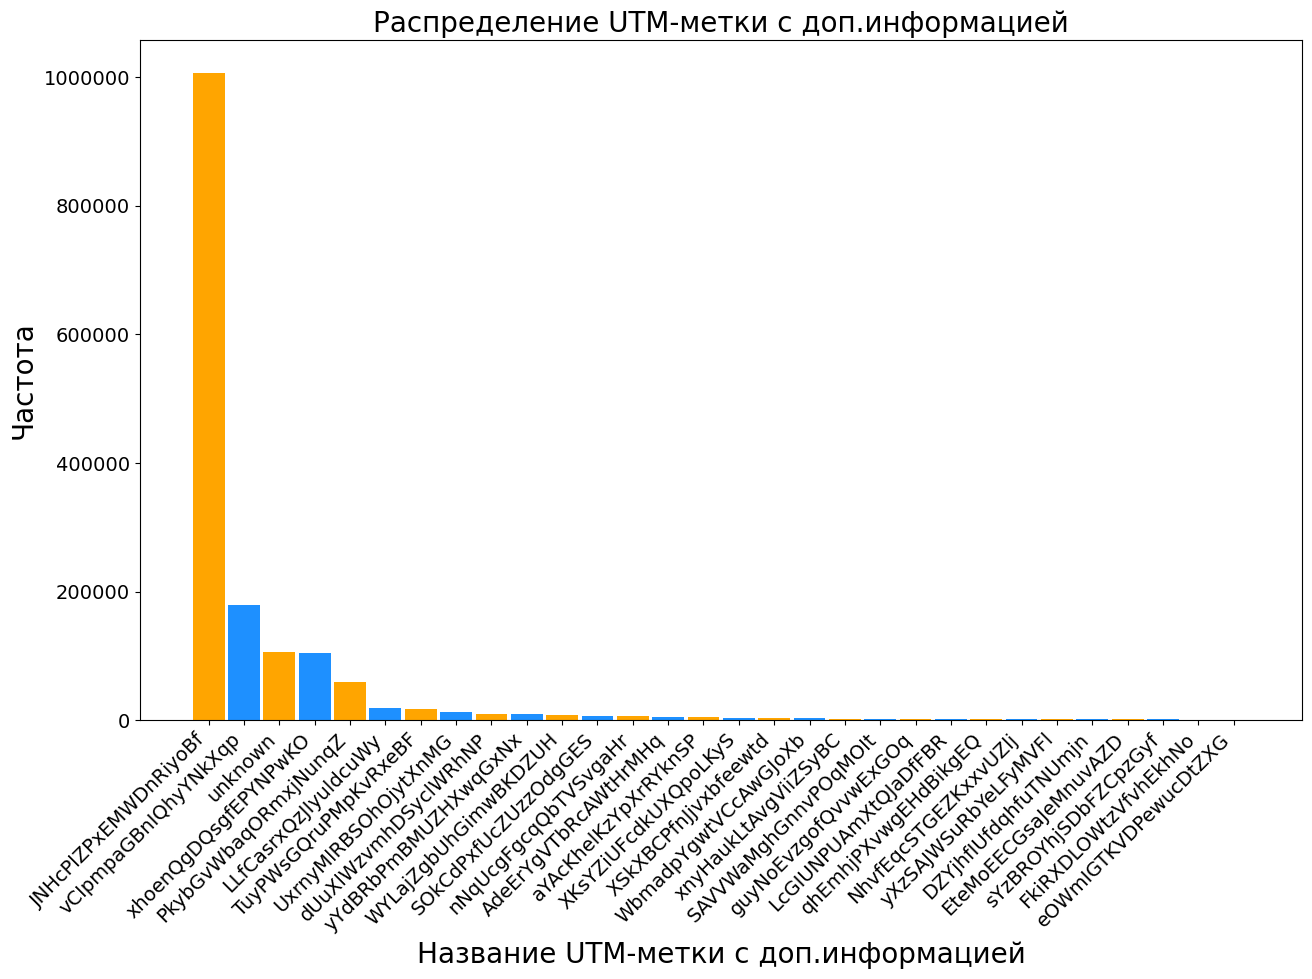

In [200]:
distribution_graph(stats_adcontent, 'utm_adcontent', (15, 10), 'UTM-метки с доп.информацией', 30)

In [201]:
stats_campaign = feature_stats(df_full, 'utm_campaign')
stats_campaign.head(5)

,utm_campaign,count
87,LTuZkdKfxRGVceoWkVyg,423139
84,LEoPHuyFvzoNfnzGgfcd,321286
39,FTjNLDyTrXaWYgZymFkV,234950
255,gecBYcKZCPMcVYdSSzKP,133247
358,unknown,60749


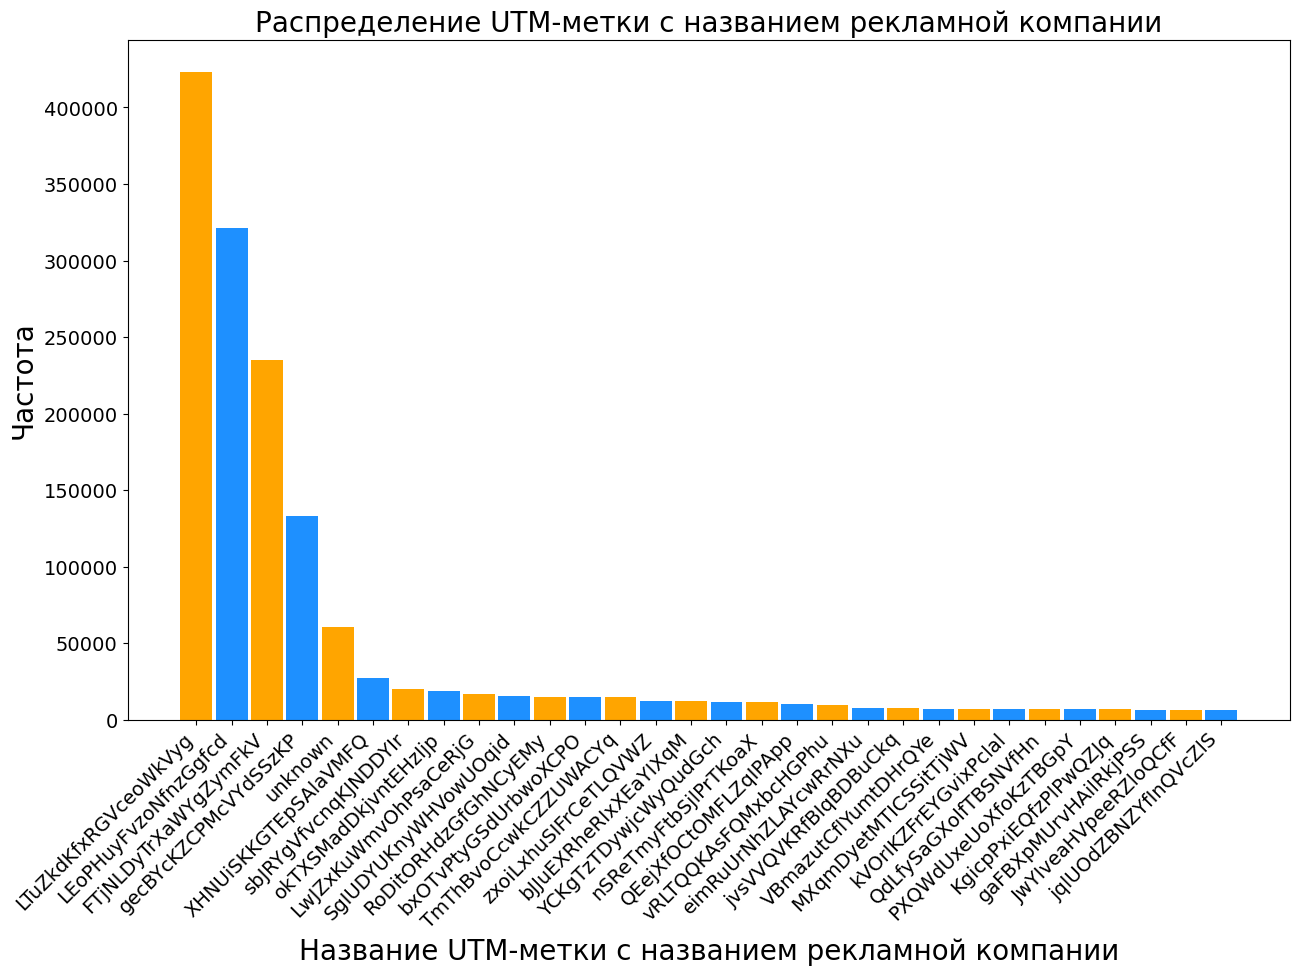

In [202]:
distribution_graph(stats_campaign, 'utm_campaign', (15, 10), 'UTM-метки с названием рекламной компании', 30)

In [203]:
stats_source = feature_stats(df_full, 'utm_source')
stats_source.head(5)

,utm_source,count
148,ZpYIoDJMcFzVoPFsHGJL,552555
175,fDLlAcSmythWSCVMvqvL,277060
209,kjsLglQLzykiRbcDiGcD,202790
77,MvfHsxITijuriZxsqZqt,175831
155,bByPQxmDaMXgpHeypKSM,85671


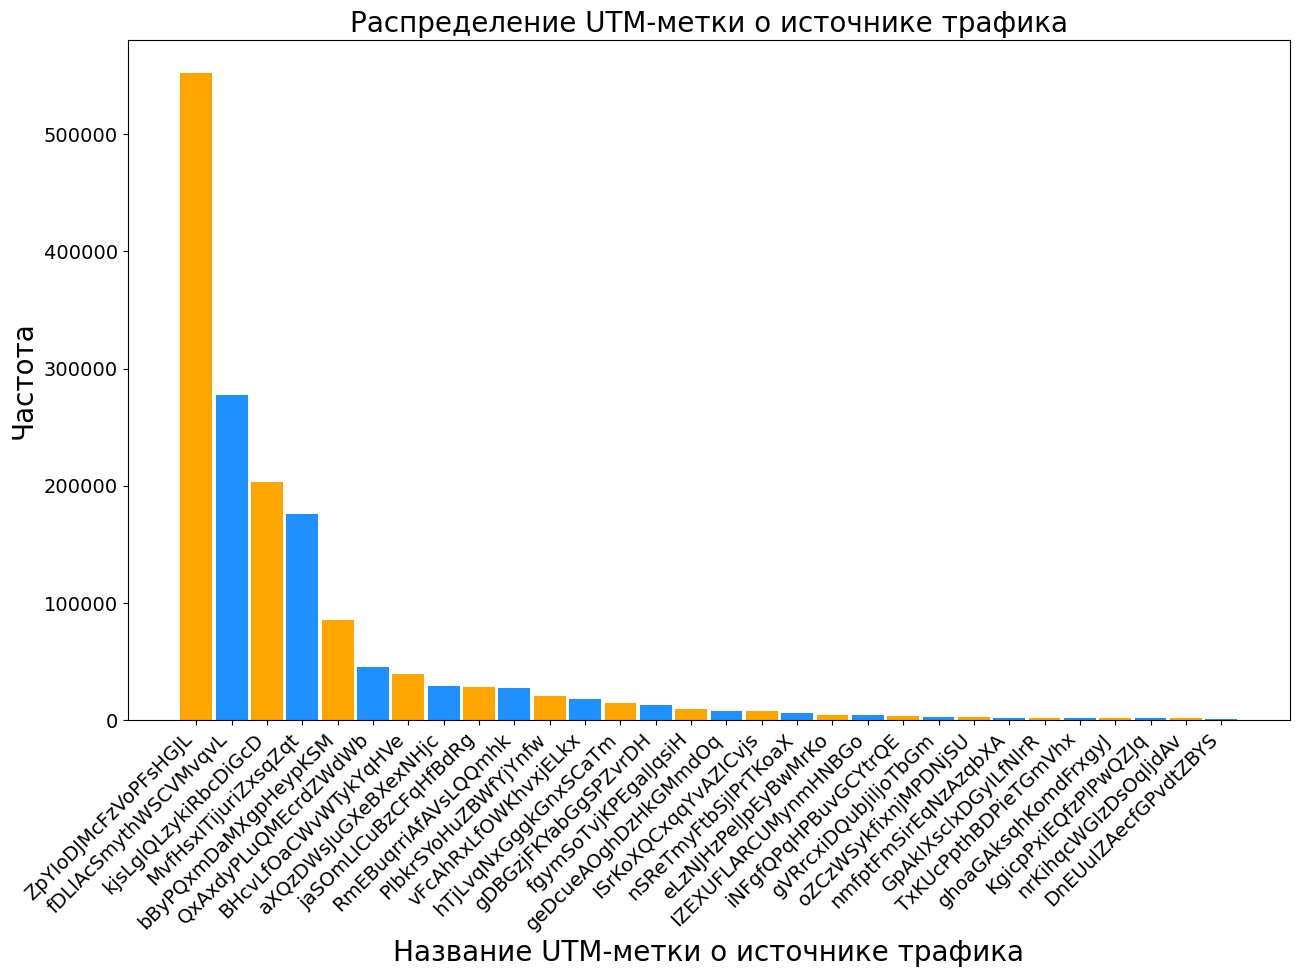

In [204]:
distribution_graph(stats_source, 'utm_source', (15, 10), 'UTM-метки о источнике трафика', 30)

In [205]:
stats_medium = feature_stats(df_full, 'utm_medium')
stats_medium.head(5)

,utm_medium,count
3,banner,525206
11,cpc,283165
0,(none),277060
12,cpm,229791
37,referral,132166


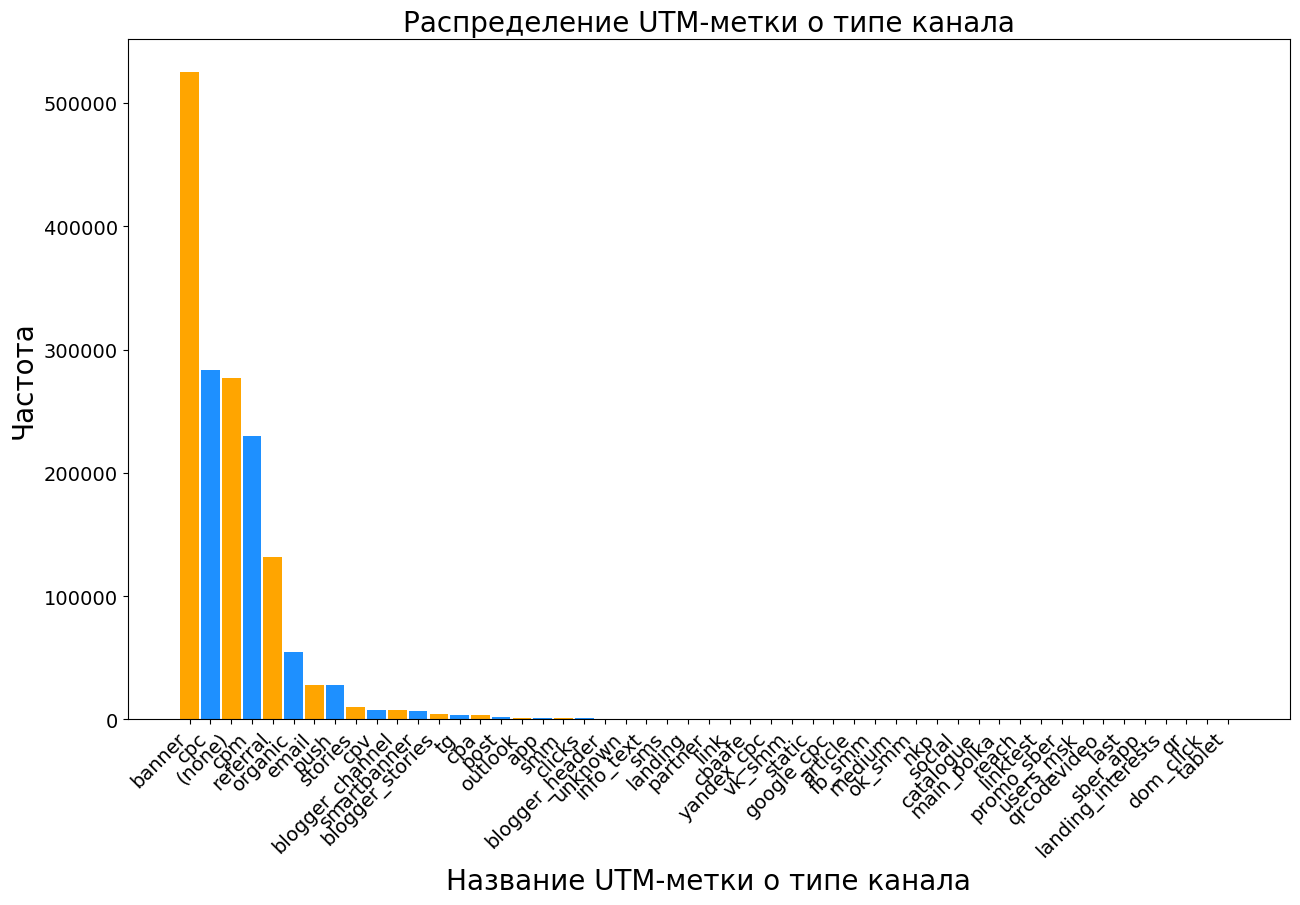

In [206]:
distribution_graph(stats_medium, 'utm_medium', (15, 10), 'UTM-метки о типе канала', 'all')

In [207]:
stats_brand = feature_stats(df_full, 'device_brand')
stats_brand.head(5)

,device_brand,count
9,Apple,483210
197,unknown,301508
142,Samsung,296983
188,Xiaomi,257952
75,Huawei,165981


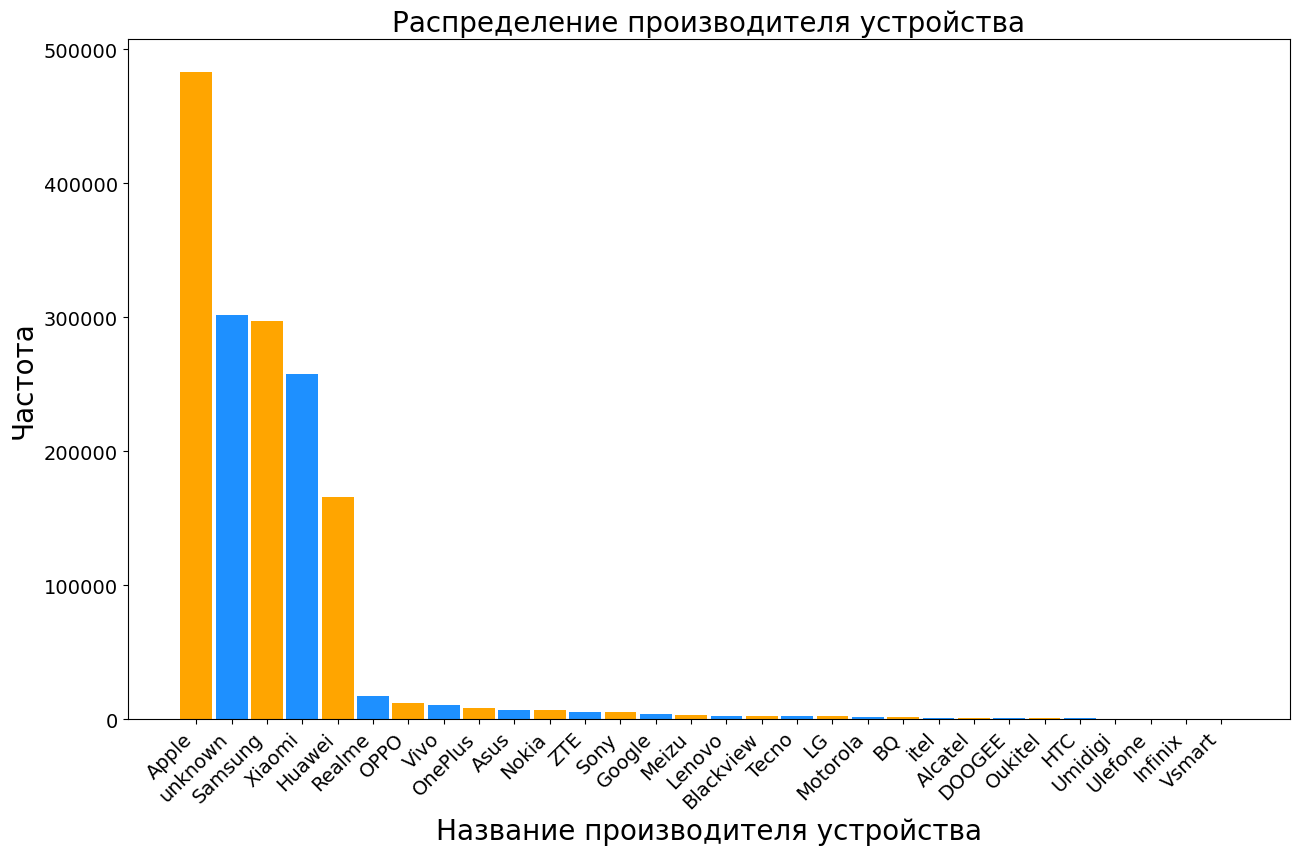

In [208]:
distribution_graph(stats_brand, 'device_brand', (15, 10), 'производителя устройства', 30)

In [209]:
stats_category = feature_stats(df_full, 'device_category')
stats_category

,device_category,count
1,mobile,1287362
0,desktop,308936
2,tablet,14977


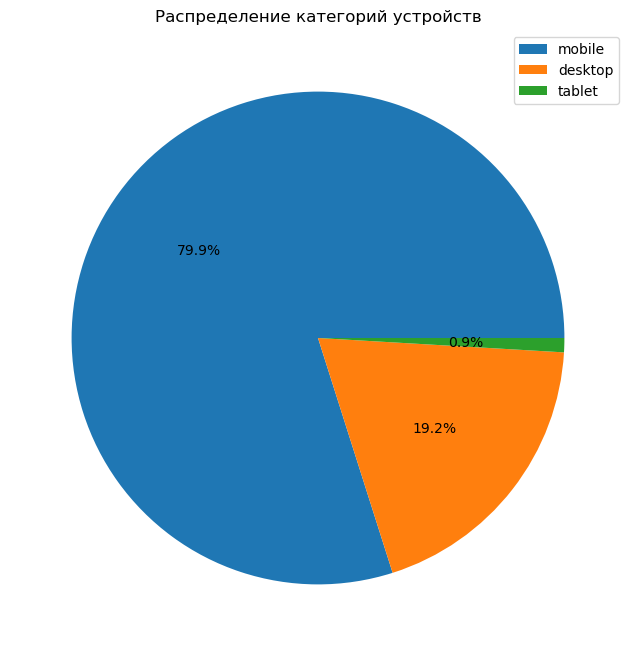

In [210]:
plt.figure(figsize=(12, 8))
plt.pie(stats_category['count'], labels=stats_category['device_category'], labeldistance=None, autopct = '%.2f%%')
plt.title("Распределение категорий устройств")
plt.legend()
plt.show();

In [211]:
stats_browser = feature_stats(df_full, 'device_browser')
stats_browser.head(5)

,device_browser,count
2,chrome,900102
19,safari,462046
24,yabrowser,106432
1,android,50610
20,samsung,41735


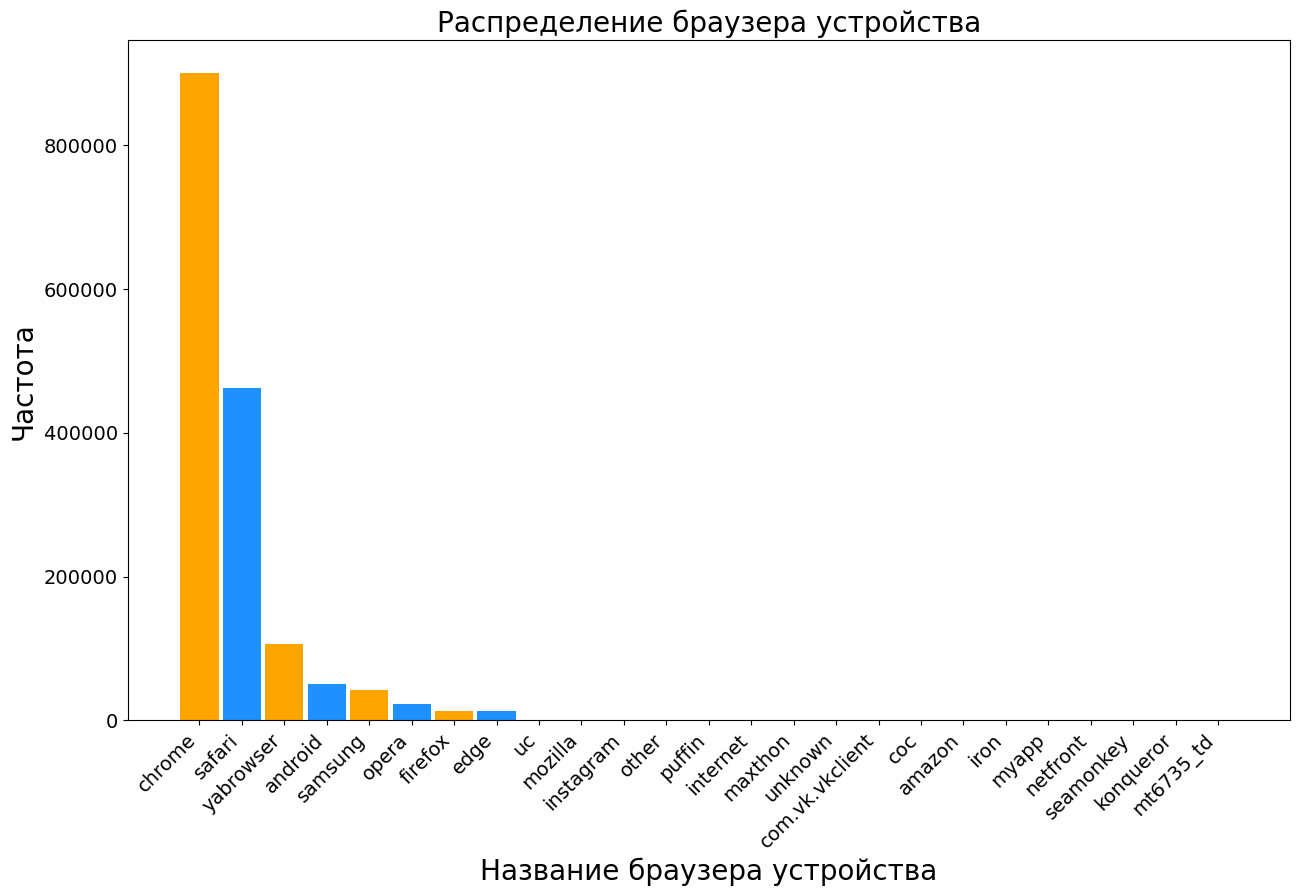

In [212]:
distribution_graph(stats_browser, 'device_browser', (15, 10), 'браузера устройства', 'all')

In [213]:
stats_city = feature_stats(df_full, 'geo_city')
stats_city.head(5)

,geo_city,count
1320,Moscow,684887
1774,Saint Petersburg,252407
2338,unknown,66083
2282,Yekaterinburg,33029
1020,Krasnodar,29709


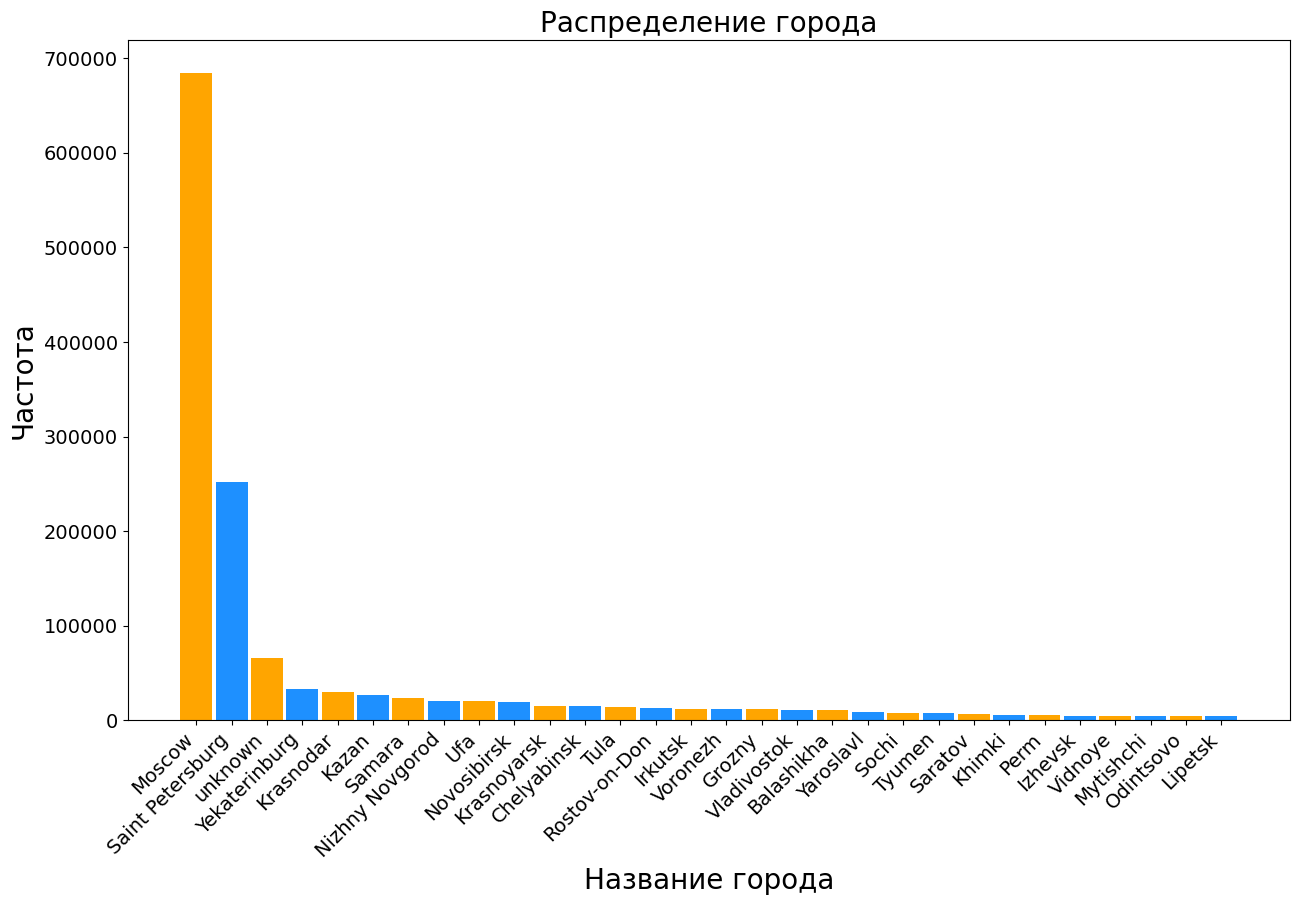

In [214]:
distribution_graph(stats_city, 'geo_city', (15, 10), 'города', 30)

In [215]:
stats_country = feature_stats(df_full, 'geo_country')
stats_country.head(5)

,geo_country,count
116,Russia,1563726
147,Ukraine,8201
150,United States,8008
15,Belarus,3148
70,Kazakhstan,2029


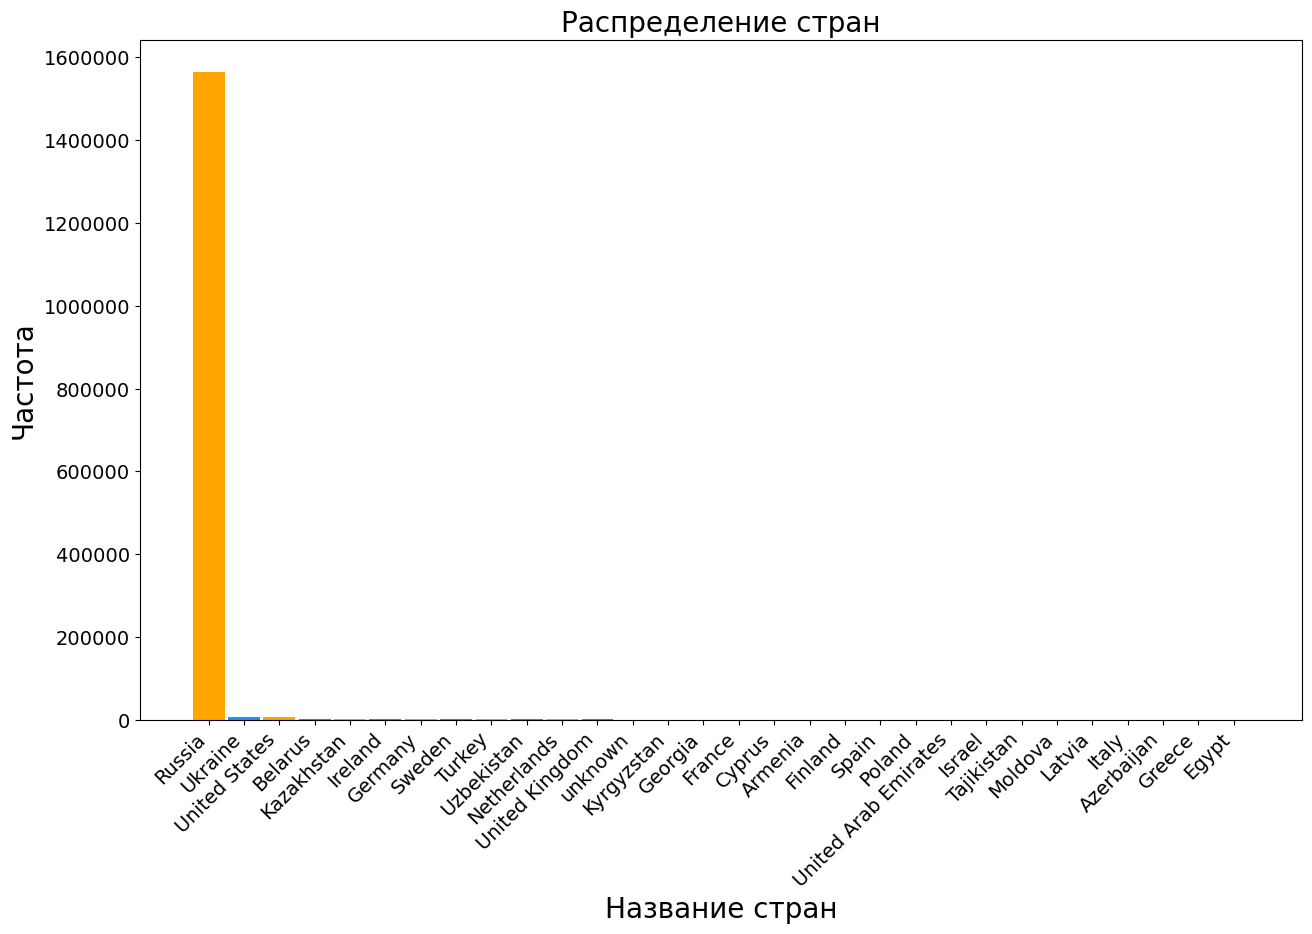

In [216]:
distribution_graph(stats_country, 'geo_country', (15, 10), 'стран', 30)

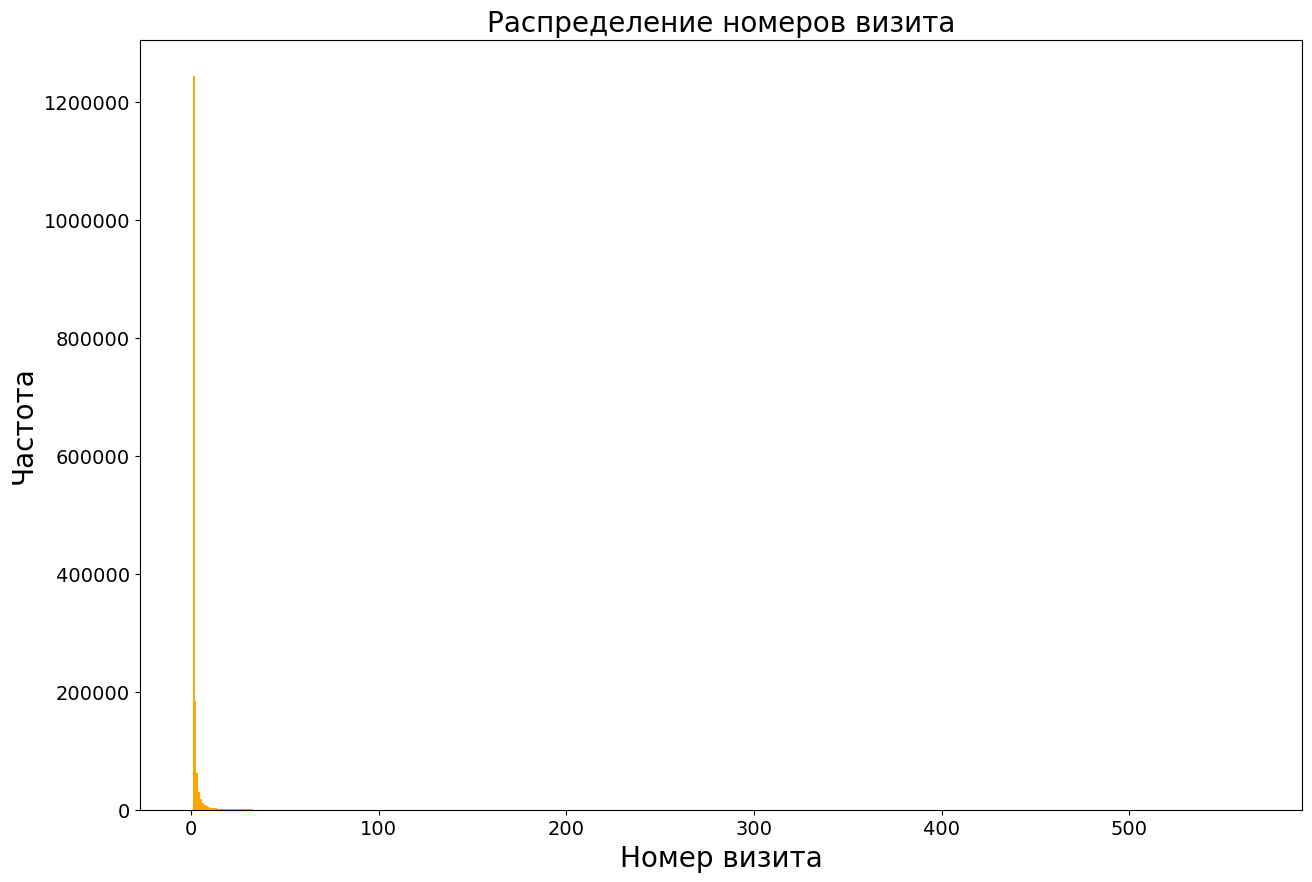

In [217]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.hist(df_full['visit_number'].values, bins=564, color=['orange'])
ax.set_xlabel('Номер визита', fontsize = 20)
ax.set_ylabel('Частота', fontsize = 20)
ax.set_title('Распределение номеров визита', fontsize = 20)
ax.tick_params(axis='both', labelsize=14)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [218]:
df_full = df_full.drop(columns=['session_id', 'client_id'])
df_full.to_csv('sberpodpiska_data_prepared.csv', index=False)

In [219]:
data = ['utm_source', 'utm_campaign', 'utm_medium', 'utm_keyword', 'utm_adcontent', 'device_browser', 'device_os', 'device_brand', 'device_category', 'geo_country', 'geo_city']
encoder = TargetEncoder()
for elem in data:
    df_full[elem+'_encoding'] = encoder.fit_transform(df_full[elem], df_full['event_action_bin'])

In [222]:
df_full.columns

Index(['visit_date', 'visit_time', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
       'device_os', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'event_action_bin',
       'utm_source_encoding', 'utm_campaign_encoding', 'utm_medium_encoding',
       'utm_keyword_encoding', 'utm_adcontent_encoding',
       'device_browser_encoding', 'device_os_encoding',
       'device_brand_encoding', 'device_category_encoding',
       'geo_country_encoding', 'geo_city_encoding'],
      dtype='object')

In [223]:
columns_for_drop = ['utm_source', 'utm_keyword', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_browser', 'device_os', 'device_category', 'geo_city', 'device_brand', 'geo_country', 'device_screen_resolution', 'visit_date', 'visit_time']
df_prepared = df_full.drop(columns=columns_for_drop,axis=1)
df_prepared.head()

,visit_number,event_action_bin,utm_source_encoding,utm_campaign_encoding,utm_medium_encoding,utm_keyword_encoding,utm_adcontent_encoding,device_browser_encoding,device_os_encoding,device_brand_encoding,device_category_encoding,geo_country_encoding,geo_city_encoding
0,1,0,0.028953,0.029096,0.028764,0.033510,0.021796,0.028008,0.027200,0.025756,0.027504,0.028546,0.014151
1,1,0,0.012791,0.010415,0.010962,0.015396,0.012186,0.027555,0.027200,0.031692,0.027504,0.028546,0.030434
2,1,0,0.028953,0.029096,0.028764,0.033510,0.021796,0.028008,0.027200,0.025756,0.027504,0.028546,0.024566
3,1,0,0.023142,0.021807,0.019335,0.012324,0.012517,0.028008,0.027200,0.024136,0.027504,0.028546,0.030434
5,1,0,0.023142,0.044936,0.038176,0.053680,0.034894,0.028110,0.027956,0.028193,0.027504,0.028546,0.024690


In [224]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611275 entries, 0 to 1732265
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   visit_number              1611275 non-null  int64  
 1   event_action_bin          1611275 non-null  int64  
 2   utm_source_encoding       1611275 non-null  float64
 3   utm_campaign_encoding     1611275 non-null  float64
 4   utm_medium_encoding       1611275 non-null  float64
 5   utm_keyword_encoding      1611275 non-null  float64
 6   utm_adcontent_encoding    1611275 non-null  float64
 7   device_browser_encoding   1611275 non-null  float64
 8   device_os_encoding        1611275 non-null  float64
 9   device_brand_encoding     1611275 non-null  float64
 10  device_category_encoding  1611275 non-null  float64
 11  geo_country_encoding      1611275 non-null  float64
 12  geo_city_encoding         1611275 non-null  float64
dtypes: float64(11), int64(2)
me

In [225]:
df_prepared.corr()

,visit_number,event_action_bin,utm_source_encoding,utm_campaign_encoding,utm_medium_encoding,utm_keyword_encoding,utm_adcontent_encoding,device_browser_encoding,device_os_encoding,device_brand_encoding,device_category_encoding,geo_country_encoding,geo_city_encoding
visit_number,1.000000,0.027272,0.073928,0.071449,0.080009,0.048260,0.054427,0.017056,0.137919,0.067826,0.140734,0.007483,0.003299
event_action_bin,0.027272,1.000000,0.082113,0.090533,0.077246,0.069472,0.062047,0.010906,0.012406,0.020531,0.011440,0.016328,0.041222
utm_source_encoding,0.073928,0.082113,1.000000,0.687410,0.837807,0.480406,0.550861,0.082658,0.070891,0.058433,0.040823,-0.016035,0.016721
utm_campaign_encoding,0.071449,0.090533,0.687410,1.000000,0.670550,0.646736,0.555459,0.058158,0.053617,0.048623,0.022500,-0.014534,0.029981
utm_medium_encoding,0.080009,0.077246,0.837807,0.670550,1.000000,0.502696,0.499774,0.085809,0.128294,0.086194,0.103073,0.001153,0.026851
utm_keyword_encoding,0.048260,0.069472,0.480406,0.646736,0.502696,1.000000,0.663091,0.010067,-0.081828,-0.022295,-0.115078,-0.002584,0.034536
utm_adcontent_encoding,0.054427,0.062047,0.550861,0.555459,0.499774,0.663091,1.000000,0.013414,-0.052504,-0.012584,-0.101589,-0.018314,0.020439
device_browser_encoding,0.017056,0.010906,0.082658,0.058158,0.085809,0.010067,0.013414,1.000000,0.152232,0.064991,0.136793,0.027213,0.019505
device_os_encoding,0.137919,0.012406,0.070891,0.053617,0.128294,-0.081828,-0.052504,0.152232,1.000000,0.452845,0.903678,-0.002061,-0.016757
device_brand_encoding,0.067826,0.020531,0.058433,0.048623,0.086194,-0.022295,-0.012584,0.064991,0.452845,1.000000,0.474865,-0.002139,-0.009206


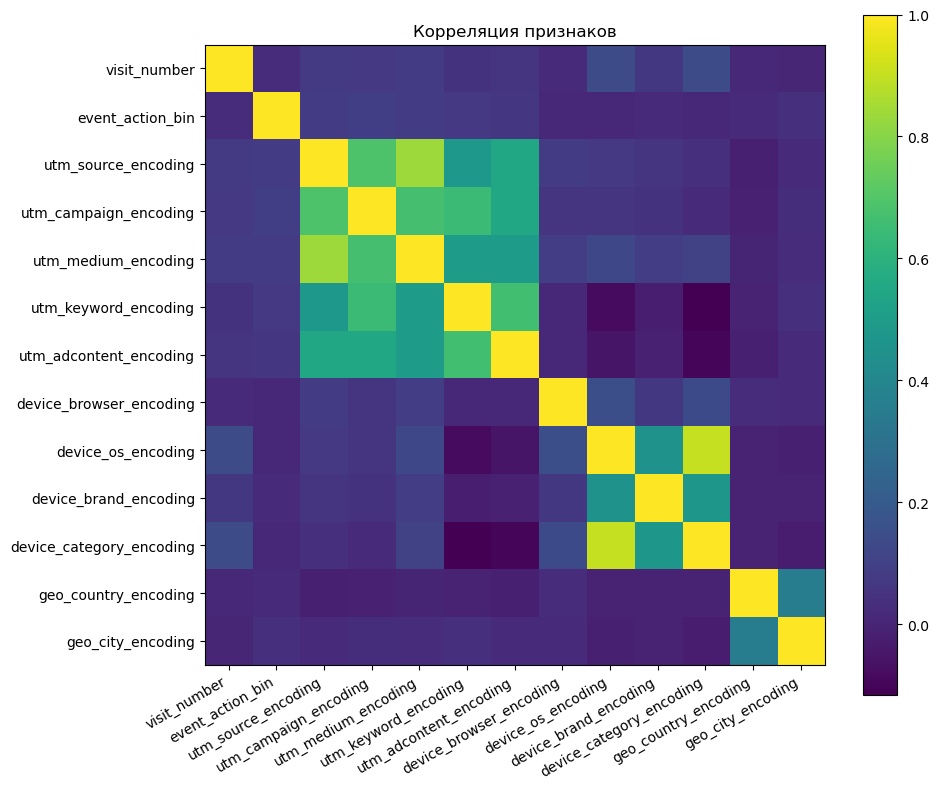

In [226]:
columns = df_prepared.corr().columns.tolist()

fig, ax = plt.subplots(figsize=(10, 10))
heatmap = ax.imshow(df_prepared.corr())
ax.set_xticks(range(0, len(columns)), columns)
ax.set_yticks(range(0, len(columns)), columns)
ax.set_title("Корреляция признаков")
fig.colorbar(heatmap)
fig.autofmt_xdate(rotation=30);

In [233]:
with open('data/sberavtopodpiska_prep.csv','wb') as file:
    file = dill.dump(df_prepared,file)